A measurement is a central concept in quantum mechanics. An easy way to think about it as a sample from a probability distribution: it is a random variable with a number of outcomes, each outcome is produced with a certain probability. 

Measurement connect the quantum world to our classical one: we cannot directly observe the quantum state in nature, we can only gather statistics about it with measurements. It sounds like a harsh boundary between a quantum and a classical system that can only be bridged by measurement. The reality is more subtle: unless a quantum system is perfectly isolated, it interacts with its surrounding environment. This leads to introduction of mixed states, which in one limit recover classical probabilities.


# More on the bra-ket notation

Before we take a deep dive into what measurements are, we need to introduce one more notation to complement the ket: it called a bra and it is denoted by $\langle\psi|$ for some quantum state $|\psi\rangle$. Together they form the bra-ket or Dirac notation. A bra is the conjugate transpose of a ket, and the other way around. This also means that a bra is a row vector. For instance, this is the bra for $|0\rangle$

In [1]:
import numpy as np
zero_ket = np.array([[1], [0]])
print("|0> ket:\n", zero_ket)
print("<0| bra:\n", zero_ket.T.conj())

|0> ket:
 [[1]
 [0]]
<0| bra:
 [[1 0]]


This makes it very easy to write dot products: if we write a bra followed by a ket, that is exactly what the dot product is. This is so common that we often drop one of the vertical bars, and just write $\langle 0|0\rangle$, for instance. Since quantum states are normalized, the inner product of any quantum state with itself is always one:

In [7]:
zero_ket.T.conj() @ zero_ket

array([[1]])

Similarly, orthogonal vectors always give 0. E.g. $\langle 0|1\rangle$:

In [8]:
one_ket = np.array([[0], [1]])
zero_ket.T.conj() @ one_ket

array([[0]])

What about a ket and a bra? That is going to be a matrix: essentially the outer product of the two vectors. Here's $|0\rangle\langle 0|$:

In [9]:
zero_ket @ zero_ket.T.conj()

array([[1, 0],
       [0, 0]])

This should look familiar: it is a projection to the first element of the canonical basis. It is true in general that $|\psi\rangle\langle\psi|$ is going to be a projector to $|\psi\rangle$. It is very intuitive: take some other quantum state $|\phi\rangle$ and apply the matrix $|\psi\rangle\langle\psi|$ on it: $|\psi\rangle\langle\psi|\phi\rangle$. Now the right-most two terms are a bra and a ket, so it is a dot product: the overlap between $|\phi\rangle$ and $|\psi\rangle$. Since this is a scalar, it just scales the left-most term, which is the ket $|\psi\rangle$, so in effect, we projected $|\phi \rangle$ on this vector.

# Measurements

A measurement in quantum mechanics is an operator-valued random variable. The theory of measurements is rich and countless questions about them are still waiting to be answered. Most quantum computers that we have today, however, only implement one very specific measurement, which makes our discussion a lot simpler. This measurement is in the canonical basis. In other words, the measurement contains two projections, $|0\rangle\langle 0|$ and $|1\rangle\langle 1|$, and this measurement can be applied to any of the qubits of the quantum computer.

We already saw how applying a projection on a vector works. If we want to make a scalar value of that, we need to add a bra to the left. For instance, for some state $|\psi\rangle$, we get a scalar for $\langle\psi|0\rangle\langle 0|\psi\rangle$. This is called the expectation value of the operator $|0\rangle\langle 0|$. To put this in context, let us apply the projection $|0\rangle\langle 0|$ on the superposition $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$, which is the column vector $\frac{1}{\sqrt{2}}\begin{bmatrix} 1\\ 0\end{bmatrix}$.

In [2]:
ψ = np.array([[1], [0]])/np.sqrt(2)
Π_0 = zero_ket @ zero_ket.T.conj()
ψ.T.conj() @ Π_0 @ ψ

array([[0.5]])

That is exactly one half, the square of the absolute value of the probability amplitude corresponding to $|0\rangle$ in the superposition! This is the mathematical formalism of what we had said earlier: given a state $|\psi\rangle = a_0|0\rangle + a_1|1\rangle$, we get an output $i$ with probability $|a_i|^2$. This is known as the *Born rule*. Now we have a recipe to extract probabilities with projections. This is exactly what is implemented in the quantum simulator. The measurement in the simulator is what we described here. Let's create an equal superposition with the Hadamard gate (see a later notebook for quantum circuits), apply the measurement, and observe the statistics:

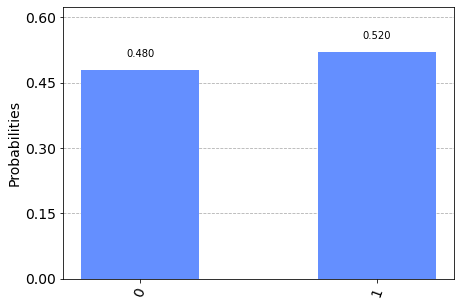

In [4]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram

backend = Aer.get_backend('qasm_simulator')
q = QuantumRegister(1)
c = ClassicalRegister(1)
circuit = QuantumCircuit(q, c)
circuit.h(q[0])
circuit.measure(q, c)
job = execute(circuit, backend, shots=100)
plot_histogram(job.result().get_counts(circuit))

You see that the outcome is random, with roughly half of the outcomes being 0.

There is something additional happening. The measurement has a random outcome, but once it is performed, the quantum state is in the corresponding basis vector. That is, the superposition is destroyed. This is referred to as the collapse of the wavefunction. It is the subject of many ongoing debates and research results how and why it happens, but what matters to us is that we can easily calculate the quantum state after the measurement. Just projecting it to the basis vector is insufficient, since that would not be normalized, so we have to renormalize it. Mathematically it is expressed by the somewhat convoluted expression $\frac{|i\rangle\langle i|\psi\rangle}{\sqrt{\langle\psi|i\rangle\langle i|\psi\rangle}}$ if we observe the output $i$. For instance, if we observe zero after measuring the superposition $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$, the state after the measurement will be

In [5]:
ψ = np.array([[np.sqrt(2)/2], [np.sqrt(2)/2]])
Π_0 = zero_ket @ zero_ket.T.conj()
probability_0 = ψ.T.conj() @ Π_0 @ ψ
Π_0 @ ψ/np.sqrt(probability_0)

array([[1.],
       [0.]])

which is just a very long way of saying we get $|0\rangle$.

You can easily see this by putting two measurements in a sequence on the same qubit. The second one will always give the same outcome as the first. The first one is random, but the second one will be determined, since there will be no superposition in the computational basis after the first measurement. Let's simulate this by writing out the results of the two measurements into two different classical registers:

In [6]:
backend = Aer.get_backend('qasm_simulator')
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.h(q[0])
circuit.measure(q[0], c[0])
circuit.measure(q[0], c[1])
job = execute(circuit, backend, shots=100)
job.result().get_counts(circuit)

{'00': 46, '11': 54}

There is no output like 01 or 10.

# Measuring multiqubit systems

Most quantum computers implement local measurements, which means that each qubit is measured separately. So if we have a two qubit system where the first qubit is in the equal superposition and the second one is in $|0\rangle$, that is, we have the state $\frac{1}{\sqrt{2}}(|00\rangle + |01\rangle)$, we will observe 0 and 0 as outcomes of the measurements on the two qubits, or 0 and 1. 

In [ ]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.h(q[0])
circuit.measure(q, c)
job = execute(circuit, backend, shots=100)
plot_histogram(job.result().get_counts(circuit))

What happens if we make measurements on an entangled state? Let's look at the statistics again on the $|\phi^+\rangle$ state:

In [ ]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.h(q[0])
circuit.cx(q[0], q[1])
circuit.measure(q, c)
job = execute(circuit, backend, shots=100)
plot_histogram(job.result().get_counts(circuit))

We only observe 00 and 11. Since the state is $\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$, this should not come as a shock. Yet, there is something remarkable going on here. At the end of the last section, we saw the same statistics, but from measurements on the same qubit. Now we have two, spatially separate qubits exhibiting the same behaviour: this is a very strong form of correlations. This means that if we measure just one qubit, and get, say, 0 as the outcome, we *know* with certainty that if we measured the other qubit, we would also get 0, even though the second measurement is also a random variable.

To appreciate this better, imagine that your are tossing two unbiased coins. If you observe heads on one, there is absolutely nothing that you can say about what the other one might be other than a wild guess that holds with probability 0.5. If you play foul and you biased the coins, you might improve your guessing accuracy. Yet you can never say with certainty what the other coin will be based on the outcome you observed on one coin, except for the trivial case when the other coin deterministically gives the same face always.

Remarkable as it is, there is no activation or instantaneous (faster than the speed of light) signalling happening between the qubits, though. Your measurement was local to the qubit and so is your information. If there is somebody else doing the measurement on the other qubit, you would have to inform the person through classical communication channels that you happen to know what the outcome will be. So while we certainly cannot violate the theory of relativity with entanglement, this strong form of correlation is still central to many quantum algorithms.

# Mixed states

If all was clear until now, this is where it gets messy. A ket and a bra is a projection, as we explained above. More than that, it is also a density matrix. A density matrix is another way of writing a quantum state, instead of kets. So, for instance we could write $\rho = |\psi\rangle\langle\psi|$, where $\rho$ is the density matrix for $|\psi\rangle$. The Born rule still applies, but now we have to take the trace of the result: for instance, $\mathrm{Tr}[|0\rangle\langle 0|\rho]$ would be the probability of seeing 0. See it in action:

In [ ]:
ψ = np.array([[1], [1]])/np.sqrt(2)
ρ = ψ @ ψ.T.conj()
Π_0 = zero_ket @ zero_ket.T.conj()
np.trace(Π_0 @ ρ)

We get one half again. The renormalization after a measurement happens in a similar way: $\frac{|0\rangle\langle 0|\rho|0\rangle\langle 0|}{\mathrm{Tr}[|0\rangle\langle 0|\rho]}$.

In [ ]:
probability_0 = np.trace(Π_0 @ ρ)
Π_0 @ ρ @ Π_0/probability_0

So why do we need this at all? Every state we have mentioned so far is called a *pure state*: these are kets or a density matrix created as a ket and a bra. There are other states called *mixed states*: these are *classical* probability distributions over pure states. Formally, a mixed state is written as $\sum_i p_i |\psi_i\rangle\langle\psi_i|$, where $\sum_i p_i=1$, $p_i\geq 0$. This reflects our classical ignorance over the underlying quantum states. Compare the density matrix of the equal superposition $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ and the mixed state $0.5(|0\rangle\langle 0|+|1\rangle\langle 1|)$:

In [ ]:
zero_ket = np.array([[1], [0]])
one_ket = np.array([[0], [1]])
ψ = (zero_ket + one_ket)/np.sqrt(2)
print("Density matrix of the equal superposition")
print(ψ @ ψ.T.conj())
print("Density matrix of the equally mixed state of |0><0| and |1><1|")
print((zero_ket @ zero_ket.T.conj()+one_ket @ one_ket.T.conj())/2)

The off-diagonal elements are gone in the second case. The off-diagonal elements are also called coherences: their presence indicates that the state is quantum. The smaller these values are, the closer the quantum state is to a classical probability distribution.

The second density matrix above has only diagonal elements and they are equal: this is the equivalent way of writing a uniform distribution. We know that the uniform distribution has maximum entropy, and for this reason, a density matrix with this structure is called a maximally mixed state. In other words, we are perfectly ignorant of which elements of the canonical basis constitute the state.

We would like a quantum state to be perfectly isolated from the environment, but in reality, the quantum computers we have today and for the next couple of years cannot achieve a high degree of isolation. So coherences are slowly lost to the environment -- this is a process called decoherence. The speed at which this happens determines the length of the quantum algorithms we can run on the quantum computer: if it happens fast, we have time to apply a handful gates or do any other form calculation, and then we quickly have to pull out (measure) the results.